(14031, 5)
        date    open    high     low   close
0 1971-01-04  0.5353  0.5353  0.5353  0.5353
1 1971-01-05  0.5350  0.5350  0.5350  0.5350
2 1971-01-06  0.5352  0.5352  0.5352  0.5352
3 1971-01-07  0.5353  0.5353  0.5353  0.5353
4 1971-01-08  0.5354  0.5354  0.5354  0.5354


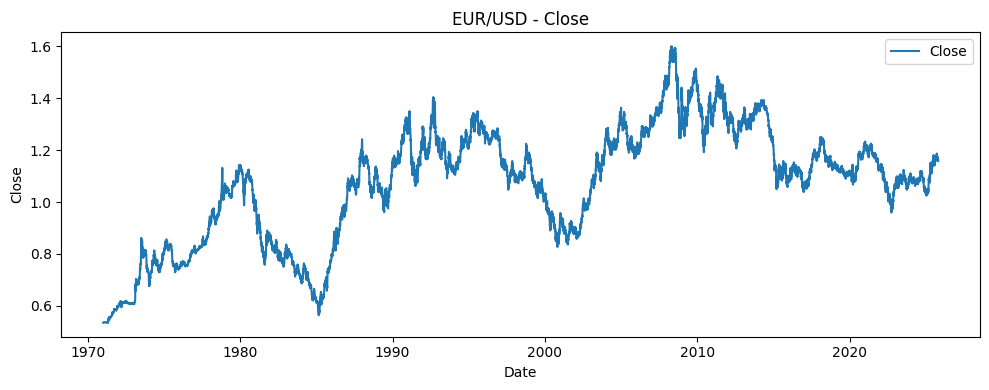

In [26]:
import sys, pathlib, importlib
import matplotlib.pyplot as plt

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

import src.data_loading as dl
importlib.reload(dl)

df = dl.load_eurusd()

print(df.shape)
print(df.head())

plt.figure(figsize=(10, 4))
plt.plot(df["date"], df["close"], label="Close")
plt.title("EUR/USD - Close")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()


Return moyen: 7.387171099178121e-05
Return std  : 0.0061291774091417365


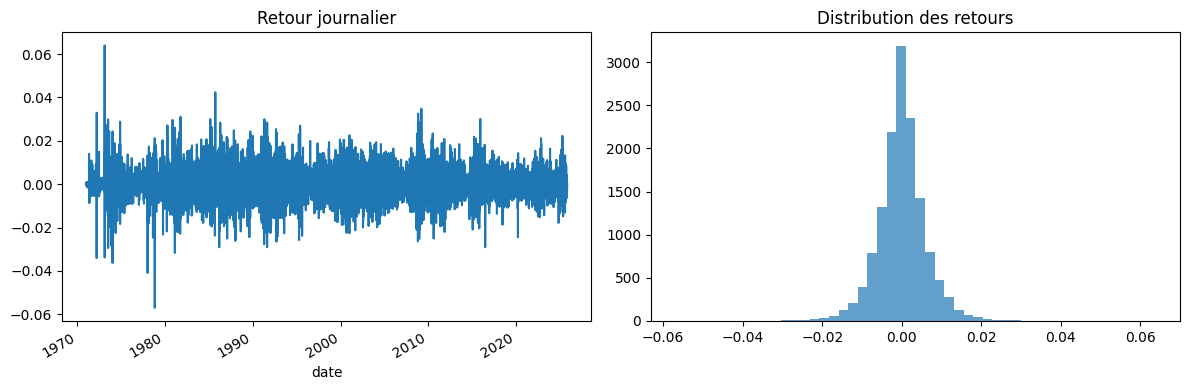

In [27]:
df["ret"] = df["close"].pct_change()
print("Return moyen:", df["ret"].mean())
print("Return std  :", df["ret"].std())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df.set_index("date")["ret"].plot(ax=axes[0], title="Retour journalier")
axes[1].hist(df["ret"].dropna(), bins=50, alpha=0.7)
axes[1].set_title("Distribution des retours")
plt.tight_layout()
plt.show()


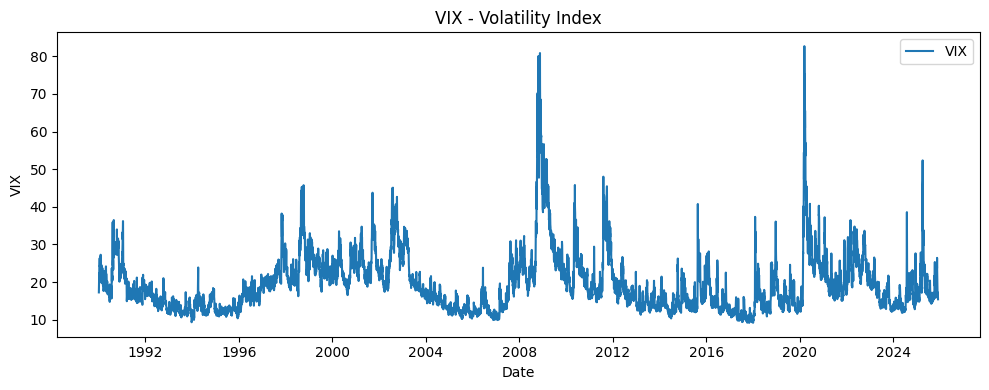

(9267, 20)
y_up
1    0.502
0    0.498
Name: proportion, dtype: float64


,date,close,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_rollmean_5,ret_rollstd_5,ret_rollstd_10,ret_rollstd_20,abs_ret_lag1,range_pct,vix_lag1
4764,1990-01-03,1.1333,-0.011262,-0.001211,0.001560,0.005080,-0.002487,0.006691,0.007207,0.006850,0.011262,0.0,17.24
4765,1990-01-04,1.1585,-0.007010,-0.011262,-0.001211,0.005490,0.000863,0.012948,0.009500,0.008245,0.007010,0.0,18.19
4766,1990-01-05,1.1605,0.022236,-0.007010,-0.011262,0.001560,0.000896,0.012950,0.009364,0.008211,0.022236,0.0,19.22
4767,1990-01-08,1.1686,0.001726,0.022236,-0.007010,-0.001211,0.002534,0.013134,0.009266,0.008135,0.001726,0.0,20.11
4768,1990-01-09,1.1594,0.006980,0.001726,0.022236,-0.011262,0.003212,0.012305,0.009541,0.008478,0.006980,0.0,20.26


In [31]:
from src.data_loading import load_eurusd
from src.modeling import train_test_split_time
from src.config import TARGET_COL, FEATURE_COLS
import matplotlib.pyplot as plt

df = load_eurusd()
vix = load_vix()

# Merge
df = df.merge(vix, on="date", how="left")
df["vix"] = df["vix"].ffill()

# Graph VIX
plt.figure(figsize=(10, 4))
plt.plot(vix["date"], vix["vix"], label="VIX")
plt.title("VIX - Volatility Index")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.legend()
plt.tight_layout()
plt.show()

df_feat = add_features(df)

X_train, X_test, y_train, y_test = train_test_split_time(df_feat, test_size=0.2)

print(df_feat.shape)
print(df_feat[TARGET_COL].value_counts(normalize=True).round(3))

# voir les nouvelles features explicitement
cols_show = ["date", "close"] + [c for c in FEATURE_COLS if c in df_feat.columns]
df_feat[cols_show].head(5)


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
pred = dummy.predict(X_test)
print("=== Dummy (most_frequent) ===")
print("Accuracy:", round(accuracy_score(y_test, pred), 3))

dummy_s = DummyClassifier(strategy="stratified", random_state=0)
dummy_s.fit(X_train, y_train)
proba = dummy_s.predict_proba(X_test)[:, 1]
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 3))


=== Dummy (most_frequent) ===
Accuracy: 0.499
ROC-AUC: 0.494


In [ ]:
from src.modeling import build_logreg_pipeline
from src.evaluation import evaluate_classifier

model = build_logreg_pipeline()
model.fit(X_train, y_train)

evaluate_classifier(model, X_train, y_train, X_test, y_test, name="LogReg baseline")


=== LogReg baseline ===
Accuracy: 0.49
ROC-AUC : 0.483
Confusion matrix:
 [[689 711]
 [720 685]]

Classification report:
               precision    recall  f1-score   support

           0      0.489     0.492     0.491      1400
           1      0.491     0.488     0.489      1405

    accuracy                          0.490      2805
   macro avg      0.490     0.490     0.490      2805
weighted avg      0.490     0.490     0.490      2805



(0.4898395721925134, 0.48317031011692935)